<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/experiment/Google_CoLab_CNN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data

In [0]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 47kB/s 
     |████████████████████████████████| 3.1MB 41.0MB/s 
     |████████████████████████████████| 501kB 40.1MB/s 


In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, GaussianNoise
from tensorflow.keras.models import Model

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D

In [34]:
tf.__version__

'2.0.0-beta1'

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
M, I, J, Ch = X_train.shape

In [0]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [0]:
X_train, X_test = X_train / np.max(X_train), X_test / np.max(X_test) # scaling

In [0]:
K = len (set(y_train))

### Dimension Check

In [40]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000,) (10000,)


# Image Augmentation

In [0]:
aug = ImageDataGenerator (rotation_range=20, horizontal_flip=True, vertical_flip=True, rescale=1.0/255.0)

In [0]:
aug.fit (X_train)

# Model Building

*Using functional API : better for split and multi-input / output*

In [0]:
i = Input (shape=(I,J,Ch))

In [0]:
# x = BatchNormalization ()(x)
# x = GlobalMaxPooling2D ()(x)
# x = GaussianNoise (0.1) (x)

In [0]:
c = 32
x = Conv2D (c, kernel_size=(3,3), activation='relu', padding='same')(i)
x = BatchNormalization ()(x)
x = Dropout (0.3)(x)

x = Conv2D (c*2, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization ()(x)
x = Dropout (0.3)(x)

x = Conv2D (c*4, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization ()(x)
x = MaxPooling2D (pool_size=(2, 2))(x)

x = Flatten ()(x)
x = Dropout (0.5)(x)

x = Dense (1024/2, activation='relu')(x)
x = Dropout (0.3)(x)

x = Dense (1024/8, activation='relu')(x)
x = Dropout (0.3)(x)

x = Dense (K, activation='softmax')(x)

In [0]:
model = Model (i, x)

In [0]:
adam = tf.keras.optimizers.Adam (learning_rate=0.001, decay=1e-6)

In [0]:
rmsp = tf.keras.optimizers.RMSprop (learning_rate=0.001, decay=1e-6)

In [0]:
model.compile (optimizer=adam,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [184]:
epochs = 10
r = model.fit_generator (aug.flow(X_train, y_train, batch_size=32), steps_per_epoch=M/32, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/10
 427/1562 [=======>......................] - ETA: 11:45 - loss: 2.5573 - accuracy: 0.1561

KeyboardInterrupt: ignored

In [115]:
print ('Training Set Evaluation : ' + str(model.evaluate (X_train, y_train)))
print ('Test Set Evaluation : ' + str(model.evaluate (X_test, y_test)))

50000/50000 [==============================] - 18s 355us/sample - loss: 1.3775 - accuracy: 0.4994
Training Set Evaluation : [1.3774813334655762, 0.49938]
10000/10000 [==============================] - 3s 349us/sample - loss: 1.3923 - accuracy: 0.4938
Test Set Evaluation : [1.392270223236084, 0.4938]


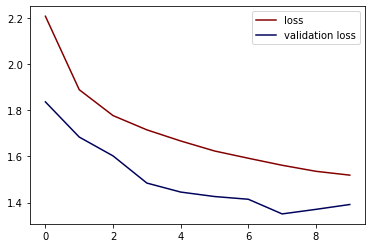

In [116]:
plt.plot (r.history['loss'], label='loss', color='#840000')
plt.plot (r.history['val_loss'], label='validation loss', color='#00035b')
plt.legend ()

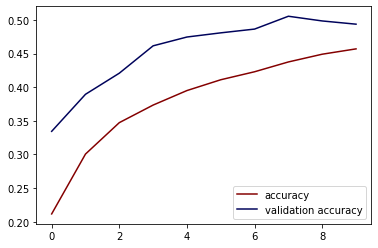

In [117]:
plt.plot (r.history['accuracy'], label='accuracy', color='#840000')
plt.plot (r.history['val_accuracy'], label='validation accuracy', color='#00035b')
plt.legend ()

In [0]:
X_test_100 = X_test[:100]
y_pred_100 = model.predict (X_test_100)

In [0]:
y_test_100 = y_test[:100]

In [0]:
y_pred_class_100 = []

In [0]:
for i in y_pred_100:
  y_pred_class_100.append (np.argmax(i))

In [0]:
y_pred_class_100 = np.array (y_pred_class_100)

### Misclassification Samples

In [0]:
misclass = np.where (y_pred_class_100 != y_test_100)[0]

In [123]:
misclass

array([ 0,  1,  3,  8, 10, 12, 13, 14, 17, 22, 23, 24, 25, 26, 27, 28, 31,
       32, 33, 35, 36, 38, 39, 40, 42, 43, 48, 52, 53, 57, 58, 59, 61, 62,
       63, 65, 67, 68, 69, 70, 74, 75, 76, 77, 83, 84, 85, 86, 87, 88, 90,
       91, 95, 99])

In [0]:
i = np.random.choice (misclass)

In [0]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [132]:
labels [y_pred_class_100[i]]

'horse'

Text(0.5, 1.0, 'True: frog, Predicted: horse')

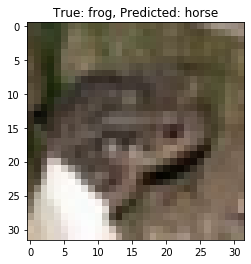

In [133]:
plt.imshow (X_test[i], cmap='gray')
plt.title ('True: %s, Predicted: %s' % (labels[y_test_100[i]], labels[y_pred_class_100[i]]))